# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


from collections import Counter

## 1.1 Reading Data

In [0]:
project_data = pd.read_csv('/content/drive/My Drive/6_Donors_choose_NB/train_data.csv')
resource_data = pd.read_csv('/content/drive/My Drive/6_Donors_choose_NB/resources.csv')
project= project_data

In [4]:
print("Number of data points in train data", project_data.shape)
print('-'*90)
print("The attributes of data :", project_data.columns.values)
print('-'*90)
project_data.head(2)

Number of data points in train data (109248, 17)
------------------------------------------------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']
------------------------------------------------------------------------------------------


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


In [5]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(5)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


# 1.2 Data Analysis

In [6]:
print("Number of resources required by id-p069063:",resource_data.groupby('id').get_group('p069063')['quantity'].sum())

Number of resources required by id-p069063: 13


Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


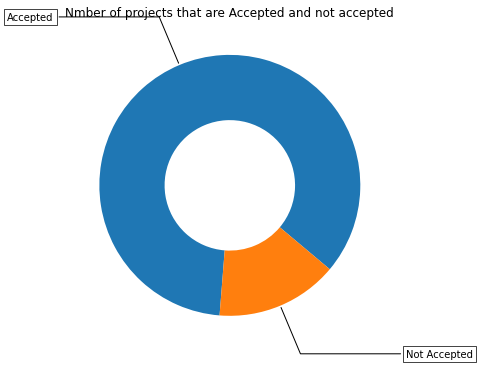

In [7]:
# PROVIDE CITATIONS TO YOUR CODE IF YOU TAKE IT FROM ANOTHER WEBSITE.
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = project_data['project_is_approved'].value_counts()

print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

### Observation
    1. We observe that majority of the projects submitted are approved by volunteers which is about 84%.

### 1.2.1 Univariate Analysis: School State

In [0]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

In [9]:
print(temp.state_code.head(5))

0    AK
1    AL
2    AR
3    AZ
4    CA
Name: state_code, dtype: object


In [10]:
print(temp.head(5))

  state_code  num_proposals
0         AK       0.840580
1         AL       0.854711
2         AR       0.831268
3         AZ       0.838379
4         CA       0.858136


In [11]:
!pip install chart_studio

In [0]:
import chart_studio.plotly as py
import plotly.graph_objs as go

In [13]:
# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )
fig = go.Figure(data=data, layout=layout)
fig.show()

### Observations
    1. North dakota and Delaware have the highest acceptance rate of project proposals.
    2. Texas has the lowest acceptance rate of project proposals.


In [14]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


In [0]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.xticks(rotation=90)
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [0]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    #accepted project count
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    #total number of submitted project count based on the category
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    #mean of submitted project_coubnt
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

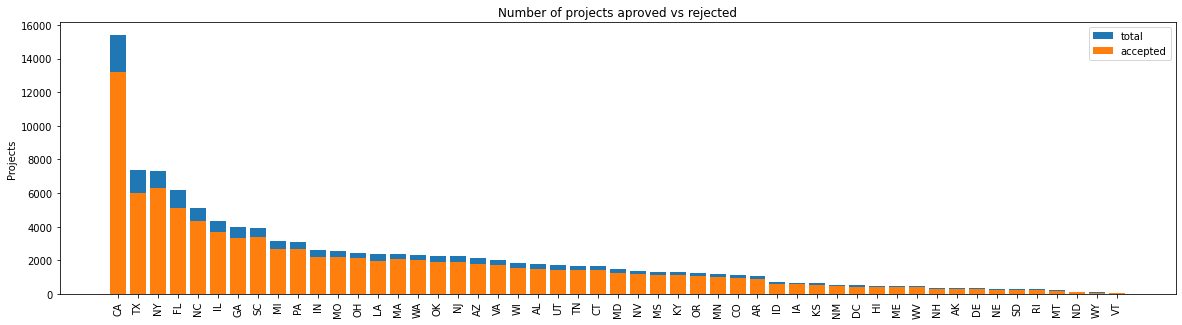

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [17]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

### Observations
    1. We observe that California has the highest number of project proposals followed by texas. 
    

__SUMMARY: Every state has greater than 80% success rate in approval__

### 1.2.2 Univariate Analysis: teacher_prefix

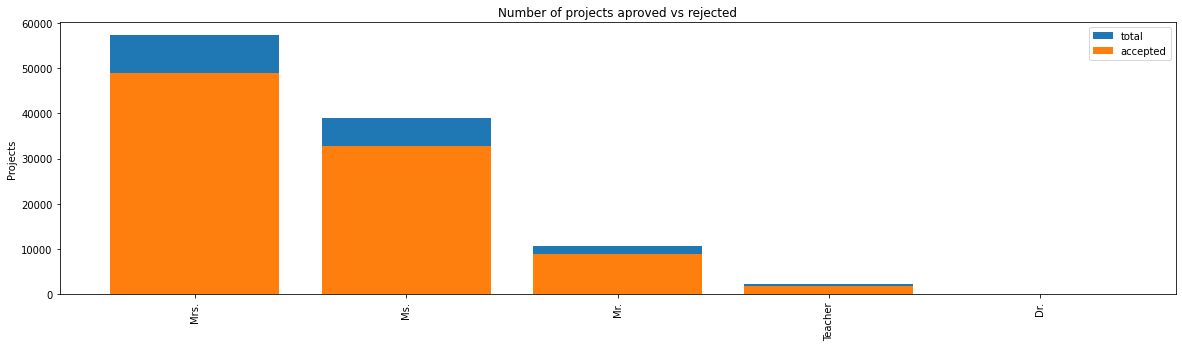

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [18]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

### Observations
    1. We observe that more than 85% of projects are proposed by lady teachers.
    2. Teachers holding a doctorate have the least number of proposals.
    3. All the teachers with respective prefixes have atleast 69% of projects approved.

### 1.2.3 Univariate Analysis: project_grade_category

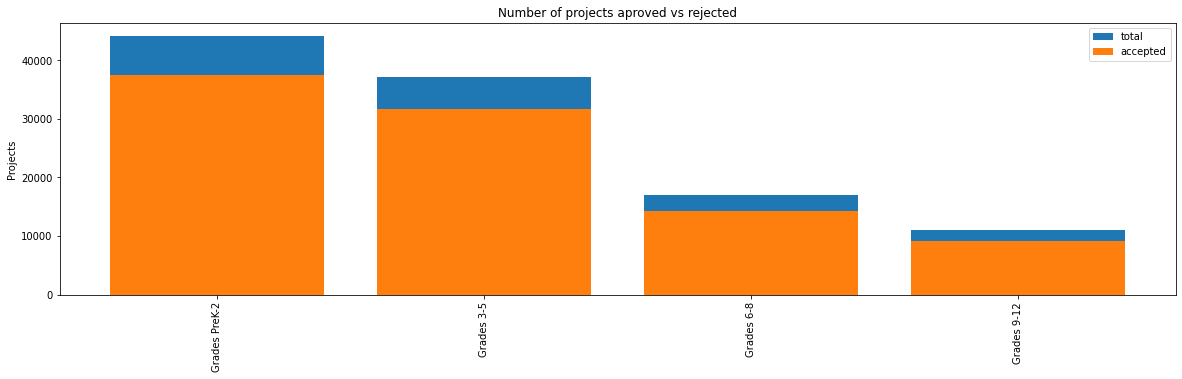

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [19]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

### Observations
    1. approximately 75% of the proposals are for kids 3rd grade and below. 
    2. Nearly all the projects in respective grade intervals have atleast 83% acceptance rate

### 1.2.4 Univariate Analysis: project_subject_categories

In [0]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [21]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports


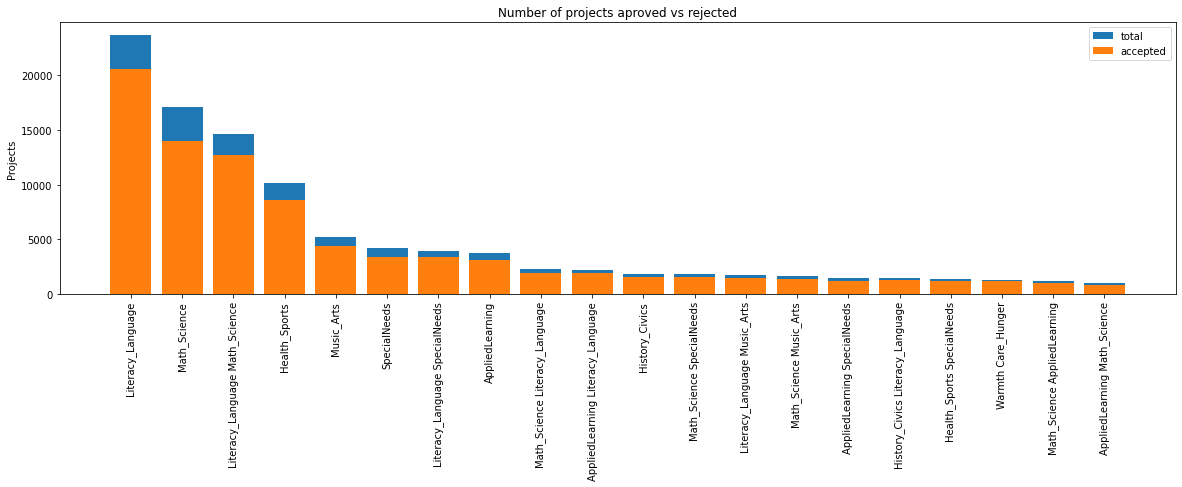

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [22]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

### Observations
    1.nearly 50% of the project proposals fall under the category of literacy language and math&science(both inclusive).
   

In [0]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

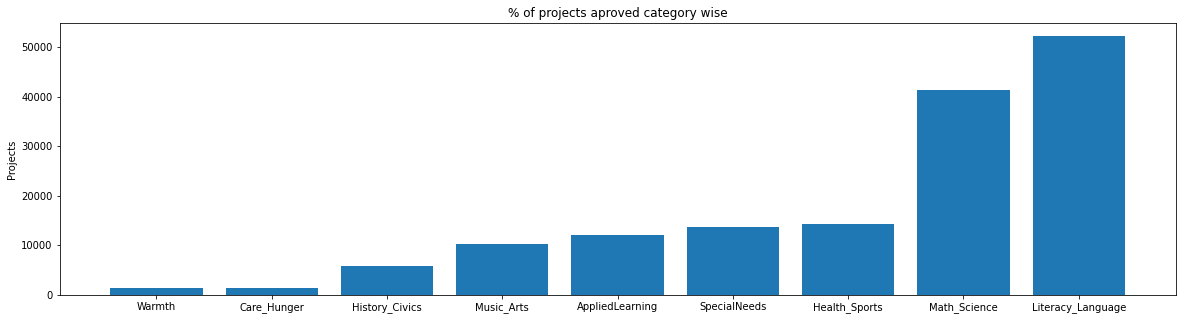

In [24]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind,list(sorted_cat_dict.keys()))
plt.show()

### Observations
    1. Projects with Warmth category have very less proposals
    2. Literacy and math categories contribute to most of the project proposals

In [25]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


### 1.2.5 Univariate Analysis: project_subject_subcategories

In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [27]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports


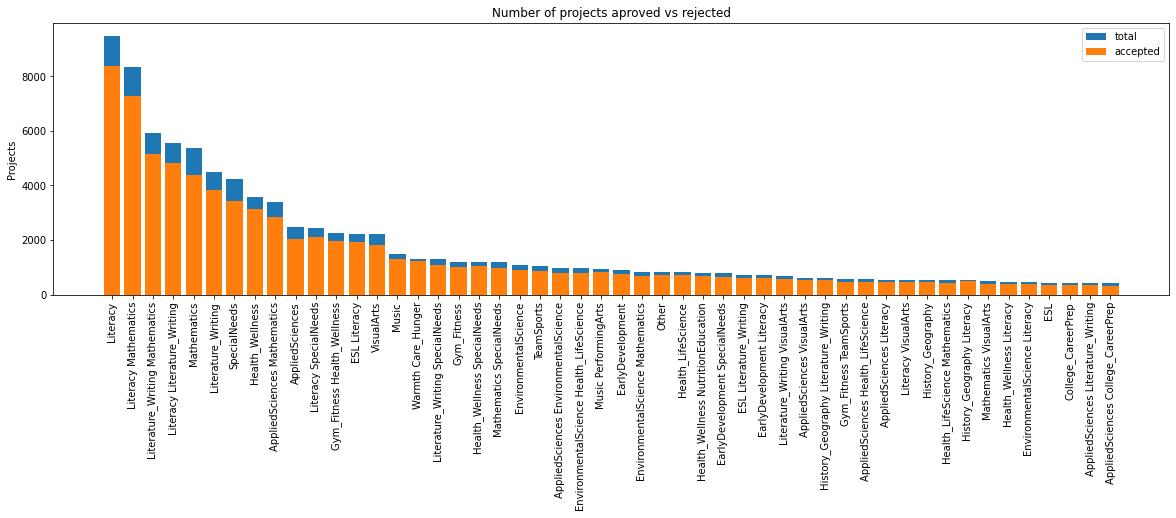

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [28]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

### Observations
    1. Under sub-categories, highest number of proposals are come under literacy category with 88% acceptance rate followed
       by literacy mathematics and literacy&writing mathematics.

In [0]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

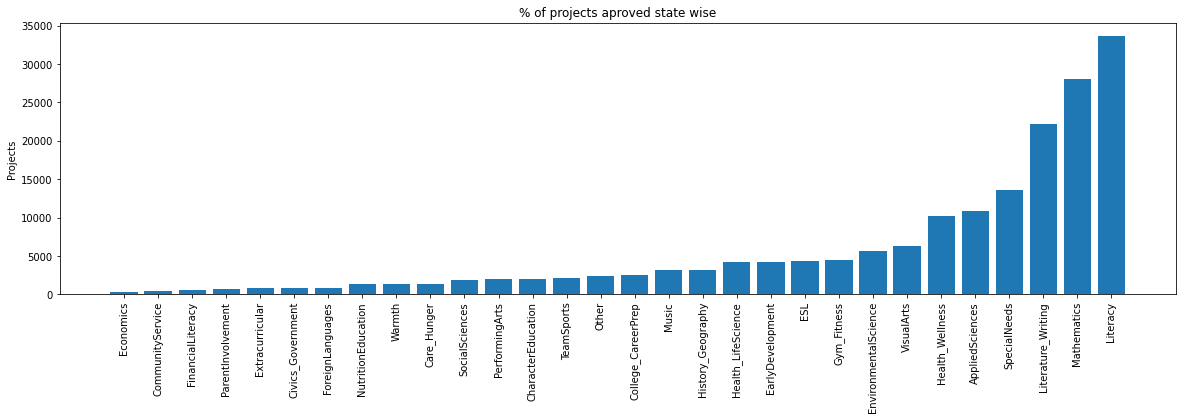

In [30]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.xticks(rotation=90)
plt.show()

In [31]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:5}".format(i,j))

Economics            :  269
CommunityService     :  441
FinancialLiteracy    :  568
ParentInvolvement    :  677
Extracurricular      :  810
Civics_Government    :  815
ForeignLanguages     :  890
NutritionEducation   : 1355
Warmth               : 1388
Care_Hunger          : 1388
SocialSciences       : 1920
PerformingArts       : 1961
CharacterEducation   : 2065
TeamSports           : 2192
Other                : 2372
College_CareerPrep   : 2568
Music                : 3145
History_Geography    : 3171
Health_LifeScience   : 4235
EarlyDevelopment     : 4254
ESL                  : 4367
Gym_Fitness          : 4509
EnvironmentalScience : 5591
VisualArts           : 6278
Health_Wellness      :10234
AppliedSciences      :10816
SpecialNeeds         :13642
Literature_Writing   :22179
Mathematics          :28074
Literacy             :33700


### 1.2.6 Univariate Analysis: Text features (Title)

4     19979
5     19677
3     18691
6     14824
7     10631
2      8733
8      7289
9      5383
10     3968
1        31
11       30
12       11
13        1
Name: project_title, dtype: int64


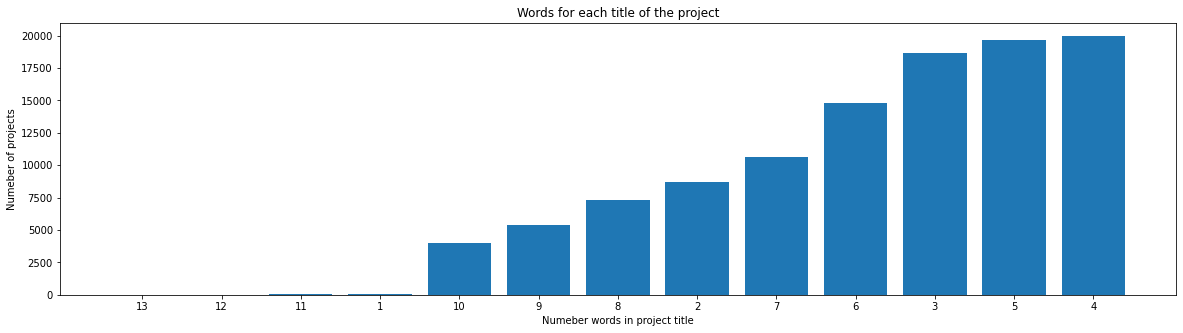

In [32]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
print(word_count)
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

### Observation
    1. We find that majority of the project titles have words between 3-6. There are few project titles with a large number 
       of words.

In [0]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

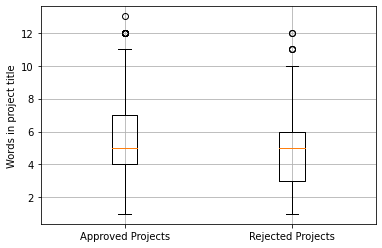

In [34]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

### Observations
    1. It can be observed that projects that are approved have more words in the project title compared to the ones which are
       not approved.

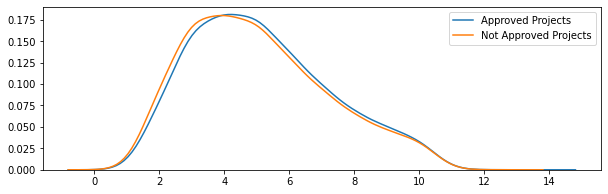

In [35]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

### Observation
    1. No significant observation can be made.

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

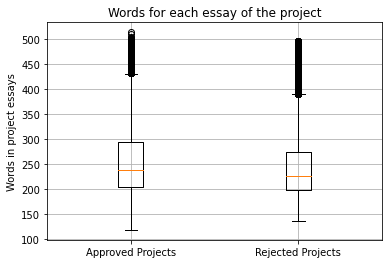

In [38]:

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))

plt.ylabel('Words in project essays')
plt.grid()
plt.show()

### Observation
    1. It can be observed that approved projects have slightly more essay content than non approved projects.

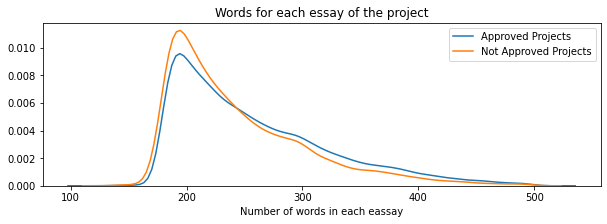

In [39]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

### Observation
    1. No significant observation can be made.

### 1.2.8 Univariate Analysis: Cost per project

In [40]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [41]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [42]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...,154.6,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...,299.0,1


In [0]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

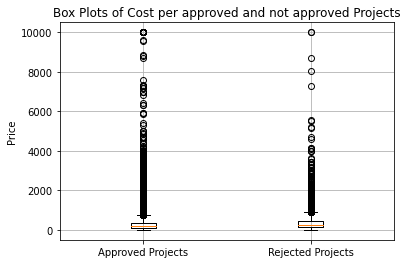

In [44]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

### Observation
    1. No significant observation can be made.

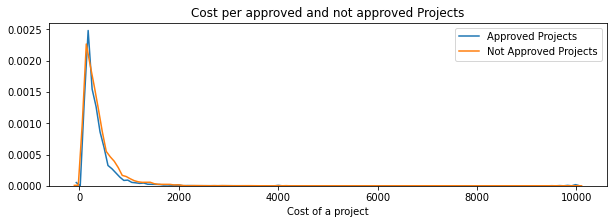

In [45]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

### Observation
    1. The rejected project proposals seem to have a higher budget requirement slightly

In [46]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

### Observation
    1. We observe that the approved projects are slightly having less budget requirement when compared to the rejected 
       projects at different percentile levels.
       

<h3><font color='black'>1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects</font></h3>

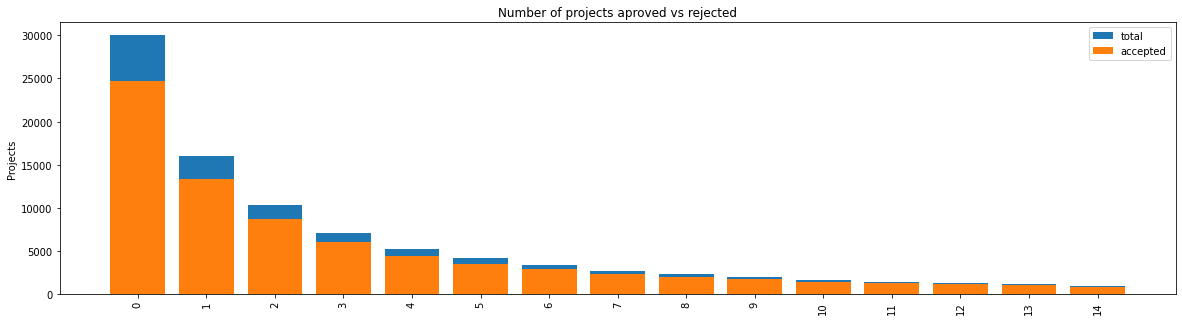

   teacher_number_of_previously_posted_projects  ...       Avg
0                                             0  ...  0.821350
1                                             1  ...  0.830054
2                                             2  ...  0.841063
3                                             3  ...  0.843460
4                                             4  ...  0.845423

[5 rows x 4 columns]
    teacher_number_of_previously_posted_projects  ...       Avg
10                                            10  ...  0.863139
11                                            11  ...  0.869986
12                                            12  ...  0.871161
13                                            13  ...  0.878378
14                                            14  ...  0.881579

[5 rows x 4 columns]


In [47]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved',top=15)

### Observations
    1. We find many of the project proposals are from teachers who are posting for the first time
    2. We observe that with increasing number of previously posted projects, the acceptance rate increases.
    3. We can also find number of projects posted by each individual.

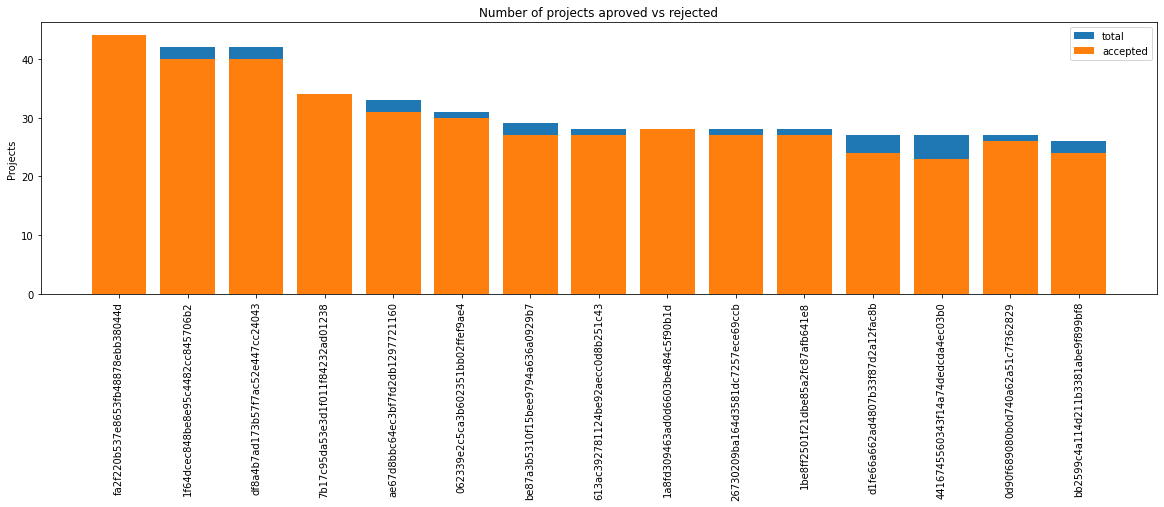

                             teacher_id  project_is_approved  total       Avg
70484  fa2f220b537e8653fb48878ebb38044d                   44     44  1.000000
8702   1f64dcec848be8e95c4482cc845706b2                   40     42  0.952381
62925  df8a4b7ad173b57f7ac52e447cc24043                   40     42  0.952381
34570  7b17c95da53e3d1f011f84232ad01238                   34     34  1.000000
49149  ae67d8bbc64ec3bf7fd2db1297721160                   31     33  0.939394
                             teacher_id  project_is_approved  total       Avg
7773   1be8ff2501f21dbe85a2fc87afb641e8                   27     28  0.964286
59152  d1fe66a662ad4807b33f87d2a12fac8b                   24     27  0.888889
19049  4416745560343f14a74dedcda4ec03b0                   23     27  0.851852
3834   0d90f689080b0d740a62a51c7f362829                   26     27  0.962963
52684  bb2599c4a114d211b3381abe9f899bf8                   24     26  0.923077


In [48]:
univariate_barplots(project_data, 'teacher_id', 'project_is_approved', top=15) #highest number of projects posted by individual

### Observations
    1. The maximum number of projects posted by an individual teacher is 44 which has 100% acceptance rate.

<h3><font color='black'>1.2.10 Univariate Analysis: project_resource_summary</font></h3>

In [49]:
print(project_data.project_resource_summary.head(5))

0    My students need opportunities to practice beg...
1    My students need a projector to help with view...
2    My students need shine guards, athletic socks,...
3    My students need to engage in Reading and Math...
4    My students need hands on practice in mathemat...
Name: project_resource_summary, dtype: object


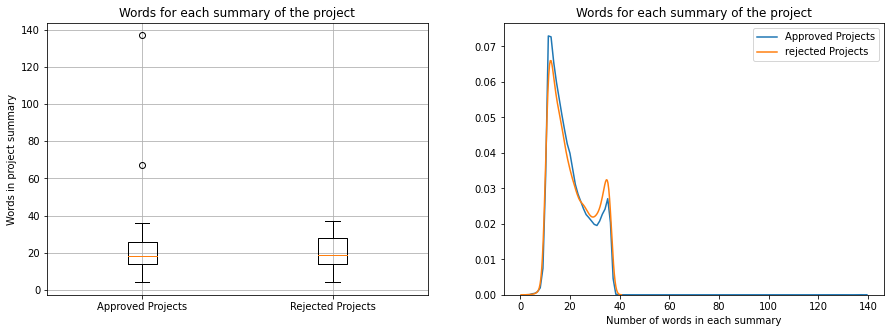

In [50]:
#boxplot and pdf
approvedw_count = project_data[project_data['project_is_approved']==1]['project_resource_summary'].str.split().apply(len)
approvedw_count = approvedw_count.values

rejectedw_count = project_data[project_data['project_is_approved']==0]['project_resource_summary'].str.split().apply(len)
rejectedw_count = rejectedw_count.values
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.boxplot([approvedw_count, rejectedw_count])
plt.title('Words for each summary of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))

plt.ylabel('Words in project summary')
plt.grid()
plt.subplot(1,2,2)
sns.distplot(approvedw_count, hist=False, label="Approved Projects")
sns.distplot(rejectedw_count, hist=False, label="rejected Projects")
plt.title('Words for each summary of the project')
plt.xlabel('Number of words in each summary')
plt.legend()

plt.show()

### Observations
    1. from above plots we can observe that the word count for resource summary is more for rejected projects which means
       the rejected projects may have more requirements.
       

In [51]:
#https://stackoverflow.com/questions/37683558/pandas-extract-number-from-string
#extracting numbers from summary and comparing the acceptance and rejection rates 
pro= project
print(project.shape)
c=pro.project_resource_summary.str.extract('(\d+)') 
pro["resource_num"]=c
pro.shape        
probool=pd.isna(pro.iloc[:][["resource_num"]])
proj= pro[probool.resource_num==False]
print("the number of rows with non zero value in resource summary: ",proj.shape)
proje= pro[probool.resource_num== True]
y_value_counts = proj['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding when summary contains a number ", y_value_counts[1], ", (", int((y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100),"%)")
print("Number of projects thar are not approved for funding when summary contains a number", y_value_counts[0], ", (", int((y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100),"%)")
print("="*120)
print("the number of rows with zero numeric digits in resource summary: ",proje.shape)
y_value_counts = proje['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding when summary doesn't contains a number ", y_value_counts[1], ", (", int((y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100),"%)")
print("Number of projects thar are not approved for funding when summary doesn't contains a number", y_value_counts[0], ", (", int((y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100),"%)")



(109248, 18)
the number of rows with non zero value in resource summary:  (15756, 19)
Number of projects thar are approved for funding when summary contains a number  14090 , ( 89 %)
Number of projects thar are not approved for funding when summary contains a number 1666 , ( 10 %)
the number of rows with zero numeric digits in resource summary:  (93492, 19)
Number of projects thar are approved for funding when summary doesn't contains a number  78616 , ( 84 %)
Number of projects thar are not approved for funding when summary doesn't contains a number 14876 , ( 15 %)


### Observations
    1. We observe that when resource summary contains numbers, the acceptance rates are slightly more compared to the one 
       which don't have numbers in resource summary.
    2. Broadly, it doesn't make much difference as the number of project proposals is 4 times more than the ones with numbers

## 1.3 Text preprocessing

### 1.3.1 Essay Text

In [52]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...,154.6,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...,299.0,1


In [53]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [56]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [57]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [58]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [60]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:55<00:00, 1955.21it/s]


In [61]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

<h3><font color='black'>1.3.2 Project title Text</font></h3>

In [62]:
# similarly you can preprocess the titles also

from tqdm import tqdm
preprocessed_titles = []
for sentance in tqdm(project["project_title"].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:02<00:00, 46199.88it/s]


In [63]:
print(project.project_title.head(5))
print("="*50)
for i in range(5):
    print(i,"   ",preprocessed_titles[i])

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
Name: project_title, dtype: object
0     educational support english learners home
1     wanted projector hungry learners
2     soccer equipment awesome middle school students
3     techie kindergarteners
4     interactive math tools


## 1. 4 Preparing data for models

In [64]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'quantity'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.4.1 Vectorizing Categorical data

In [65]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (109248, 9)


In [66]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109248, 30)


In [67]:
# Please do the similar feature encoding with state, teacher_prefix and project_grade_category also
#state encoding
my_count = Counter()
for wor in project_data['school_state'].values:
    my_count.update(wor.split())
cat_dicti = dict(my_count)
sorted_cat_dicti = dict(sorted(cat_dicti.items(), key=lambda kv: kv[1]))

vectorize = CountVectorizer(vocabulary=list(sorted_cat_dicti.keys()), lowercase=False, binary=True)
vectorize.fit(project_data['school_state'].values)
print(vectorize.get_feature_names())


categories_state = vectorize.transform(project_data['school_state'].values)
print("Shape of matrix after one hot encodig ",categories_state.shape)

#print(cat_dicti)
#print(sorted_cat_dicti)



['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of matrix after one hot encodig  (109248, 51)


In [68]:
#teacher_prefix encoding
from tqdm import tqdm
import string
project_data["teacher_prefix"].fillna("None", inplace = True)
#https://www.geeksforgeeks.org/python-pandas-dataframe-fillna-to-replace-null-values-in-dataframe/
#print(c.head(5))
#project_data["cleaned_teacher_prefix"]= c
print(project_data.teacher_prefix.head(1))
my_coun = Counter()
for wo in project_data.teacher_prefix.values:
    my_coun.update(wo.split())
cat_dictio = dict(my_coun)
sorted_cat_dictio = dict(sorted(cat_dictio.items(), key=lambda kv: kv[1]))

vectoriz = CountVectorizer(vocabulary=list(sorted_cat_dictio.keys()), lowercase=False, binary=True)
vectoriz.fit(project_data['teacher_prefix'].values)
print(vectoriz.get_feature_names())
categories_prefix = vectoriz.transform(project_data['teacher_prefix'].values)
print("Shape of matrix after one hot encoding ",categories_prefix.shape)


0    Mrs.
Name: teacher_prefix, dtype: object
['None', 'Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']
Shape of matrix after one hot encoding  (109248, 6)


In [69]:
my_count = Counter()
for w in project_data['project_grade_category'].values:
    my_count.update(w.split(","))
cat_dic = dict(my_count)
sorted_cat_dic = dict(sorted(cat_dic.items(), key=lambda kv: kv[1]))

vector = CountVectorizer(vocabulary=list(sorted_cat_dic.keys()), lowercase=False, binary=True)
vector.fit(project_data['project_grade_category'].values)
print(vector.get_feature_names())


categories_grade = vector.transform(project_data['project_grade_category'].values)
print("Shape of matrix after one hot encoding ",categories_grade.shape)

['Grades 9-12', 'Grades 6-8', 'Grades 3-5', 'Grades PreK-2']
Shape of matrix after one hot encoding  (109248, 4)


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 Bag of words

In [70]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix ",text_bow.shape)


Shape of matrix  (109248, 16623)


<h4><font color='black'> 1.4.2.2 Bag of Words on `project_title`</font></h4>

In [71]:
# you can vectorize the title also 
# before you vectorize the title make sure you preprocess it
vectorizer = CountVectorizer(min_df=4)
text_bowt = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix ",text_bowt.shape)


Shape of matrix  (109248, 5848)


#### 1.4.2.3 TFIDF vectorizer

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 16623)


<h4><font color='black'> 1.4.2.4 TFIDF Vectorizer on `project_title`</font></h4>

In [73]:
# Similarly you can vectorize for title also
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=3)
text_tfidft = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix ",text_tfidft.shape)

Shape of matrix  (109248, 7013)


#### 1.4.2.5 Using Pretrained Models: Avg W2V

In [0]:

# # Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
# def loadGloveModel(gloveFile):
#     print ("Loading Glove Model")
#     f = open(gloveFile,'r', encoding="utf8")
#     model = {}
#     for line in tqdm(f):
#         splitLine = line.split()
#         word = splitLine[0]
#         embedding = np.array([float(val) for val in splitLine[1:]])
#         model[word] = embedding
#     print ("Done.",len(model)," words loaded!")
#     return model
# model = loadGloveModel('glove_vectors')

# # ============================
# Output:
    
# Loading Glove Model
# 1917495it [06:32, 4879.69it/s]
# Done. 1917495  words loaded!

# # ============================

# words = []
# for i in preproced_texts:
#     words.extend(i.split(' '))

# for i in preproced_titles:
#     words.extend(i.split(' '))
# print("all the words in the coupus", len(words))
# words = set(words)
# print("the unique words in the coupus", len(words))

# inter_words = set(model.keys()).intersection(words)
# print("The number of words that are present in both glove vectors and our coupus", \
#       len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

# words_courpus = {}
# words_glove = set(model.keys())
# for i in words:
#     if i in words_glove:
#         words_courpus[i] = model[i]
# print("word 2 vec length", len(words_courpus))


# # stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

# import pickle
# with open('glove_vectors', 'wb') as f:
#     pickle.dump(words_courpus, f)


#we don't need that cell, the output of the above cell is glove_vector which we just downloaded

In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('/content/drive/My Drive/6_Donors_choose_NB/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [76]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors[0]))

100%|██████████| 109248/109248 [00:26<00:00, 4121.08it/s]

300


In [77]:
np.array(avg_w2v_vectors).reshape(-1,1)

array([[-0.01273977],
       [ 0.07688535],
       [ 0.03026812],
       ...,
       [ 0.07704857],
       [ 0.14392886],
       [ 0.03804371]])

<h4><font color='black
'> 1.4.2.6 Using Pretrained Models: AVG W2V on `project_title`</font></h4>

In [78]:
# Similarly you can vectorize for title also
avg_w2vt=[]
for sentence in tqdm(preprocessed_titles):
    vector= np.zeros(300)
    cnt= 0
    for word in sentence.split():
        if word in glove_words:
            vector= vector+model[word]
            cnt= cnt+1
    if cnt!=0:
        vector = vector/cnt
    avg_w2vt.append(vector)
print(len(avg_w2vt)) 
print(len(avg_w2vt[100]))
            

100%|██████████| 109248/109248 [00:01<00:00, 87579.23it/s]

109248
300


In [0]:
avg_w2vt_array=np.array(avg_w2vt)

#### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [81]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|██████████| 109248/109248 [02:59<00:00, 608.66it/s]

109248
300


In [82]:
tfidf_models = TfidfVectorizer()
tfidf_models.fit(preprocessed_titles)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_models.get_feature_names(), list(tfidf_models.idf_)))
tfidf_words_t = set(tfidf_models.get_feature_names())

tfidf_w2vt = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_t):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2vt.append(vector)

print(len(tfidf_w2vt))
print(len(tfidf_w2vt[0]))

100%|██████████| 109248/109248 [00:02<00:00, 39383.12it/s]

109248
300


In [83]:
tfidf_w2vt_array= np.array(tfidf_w2vt)
tfidf_w2vt_array.shape

(109248, 300)

### 1.4.3 Vectorizing Numerical features

In [84]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


In [85]:
price_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

In [86]:
#teacher_no_previously_posted_projects
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'quantity'],
      dtype='object')

### 1.4.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [89]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(text_bowt.shape)
print(price_standardized.shape)

(109248, 9)
(109248, 30)
(109248, 16623)
(109248, 5848)
(109248, 1)


In [90]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
X.shape

(109248, 16663)

<h2> 2.1 TSNE with `BOW` encoding of `project_title` feature </h2>

In [91]:
#concatenating all features
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bowt.shape)
print(price_standardized.shape)
print(categories_state.shape)
print(categories_grade.shape)
print(categories_prefix.shape)
from scipy.sparse import hstack
X = hstack((categories_one_hot, sub_categories_one_hot, text_bowt, price_standardized, categories_state, categories_grade, categories_prefix))
print("bow= ",X.shape)
print("="*50)
X_tfidf= hstack((categories_one_hot, sub_categories_one_hot, text_tfidft, price_standardized, categories_state, categories_grade, categories_prefix))
print("tfidf= ",X_tfidf.shape)
print("="*50)
X_avg_w2v= hstack((categories_one_hot, sub_categories_one_hot, avg_w2vt_array, price_standardized, categories_state, categories_grade, categories_prefix))
print("Average W2v= ",X_avg_w2v.shape)
print("="*50)
X_tfidf_w2v= hstack((categories_one_hot, sub_categories_one_hot, tfidf_w2vt_array, price_standardized, categories_state, categories_grade, categories_prefix))
print("tfidf w2v= ",X_tfidf_w2v.shape)



(109248, 9)
(109248, 30)
(109248, 5848)
(109248, 1)
(109248, 51)
(109248, 4)
(109248, 6)
bow=  (109248, 5949)
tfidf=  (109248, 7114)
Average W2v=  (109248, 401)
tfidf w2v=  (109248, 401)


   Dimension_x  Dimension_y  status
0   -45.796627     4.980403     0.0
1    44.333065    42.411560     1.0
2    43.076660    41.821621     0.0
3   -37.789391   -20.337910     1.0
4     4.129222   -48.402332     1.0


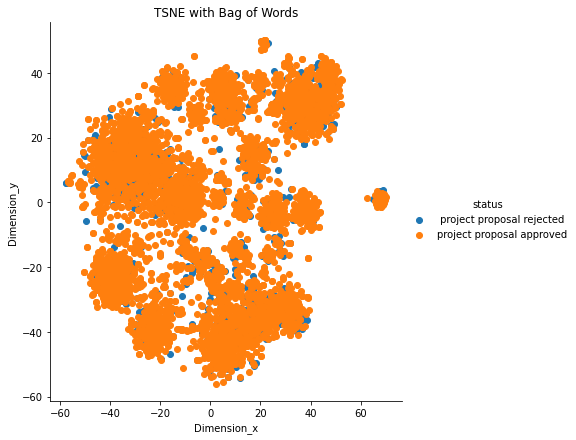

In [92]:
# please write all of the code with proper documentation and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.sparse import coo_matrix
x1= X.tocsr()#https://stackoverflow.com/questions/30163830/accessing-elements-in-coo-matrix
x = x1[:5000]#taking first 5000 rows
y = project_data.project_is_approved
z= y.values.reshape(-1,1) #coverting it into a 1-d matrix
z1= z[:5000]
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())#converting sparse to dense matrix
for_tsne = np.hstack((X_embedding, z1))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','status'])
print(for_tsne_df.head(5))
for_tsne_df.status = for_tsne_df.status.map({0.0:" project proposal rejected", 1.0: "project proposal approved"})
plt.show()    
sns.FacetGrid(for_tsne_df, hue="status", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title('TSNE with Bag of Words')
plt.show() 

### Observations
    1. After performing Tsne on bag of words, we see small clusters separating out. 
    2. Most of the points are overlapping with each other and find any segregration between projects that are approved and
       projects that are rejected.

<h2> 2.2 TSNE with `TFIDF` encoding of `project_title` feature </h2>

   Dimension_x  Dimension_y  status
0    61.380329     6.964920     0.0
1   -83.863335     4.621590     1.0
2   -63.307121    10.921556     0.0
3    46.907635   -50.972401     1.0
4   -16.647167   -34.746861     1.0


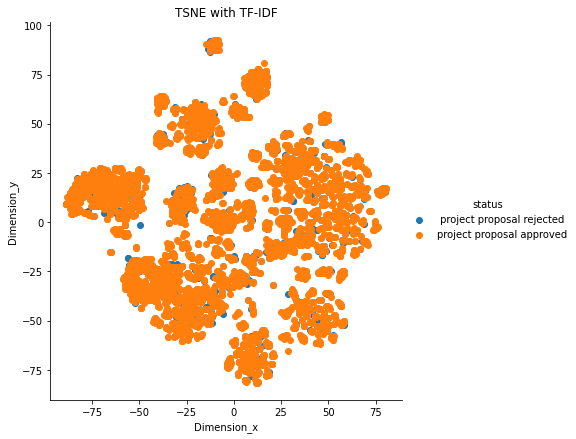

In [93]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.sparse import coo_matrix
x1= X_tfidf.tocsr()#https://stackoverflow.com/questions/30163830/accessing-elements-in-coo-matrix
x = x1[:5000]#taking first 5000 rows
y = project_data.project_is_approved
z= y.values.reshape(-1,1) #coverting it into a 1-d matrix
z1= z[:5000]
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())#converting sparse to dense matrix
for_tsne = np.hstack((X_embedding, z1))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','status'])
print(for_tsne_df.head(5))
for_tsne_df.status = for_tsne_df.status.map({0.0:" project proposal rejected", 1.0: "project proposal approved"})
plt.show()    
sns.FacetGrid(for_tsne_df, hue="status", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title('TSNE with TF-IDF')
plt.show() 

### Observations
    1. After performing TSNE With TF-IDF along with other features, we get TSNE plot without much visualisation.
    2. We can't find any distinct pattern between projects that are approved and projects thar are rejected

   Dimension_x  Dimension_y  status
0    41.994183   -27.970940     0.0
1   -45.232967    19.784517     1.0
2   -72.314110    -5.693840     0.0
3    40.602703    -0.173275     1.0
4    22.020111    39.974815     1.0


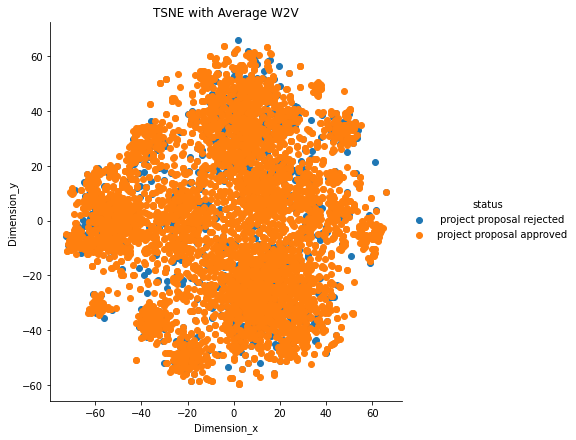

In [94]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.sparse import coo_matrix
x1= X_avg_w2v.tocsr()#https://stackoverflow.com/questions/30163830/accessing-elements-in-coo-matrix
x = x1[:5000]#taking first 5000 rows
y = project_data.project_is_approved
z= y.values.reshape(-1,1) #coverting it into a 1-d matrix
z1= z[:5000]
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())#converting sparse to dense matrix
for_tsne = np.hstack((X_embedding, z1))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','status'])
print(for_tsne_df.head(5))
for_tsne_df.status = for_tsne_df.status.map({0.0:" project proposal rejected", 1.0: "project proposal approved"})
plt.show()    
sns.FacetGrid(for_tsne_df, hue="status", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title('TSNE with Average W2V')
plt.show()     
    

### Observations
    1. We find TSNE with Average W2V more dense and most of the points are overlapping with each other.

<h2> 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature </h2>

   Dimension_x  Dimension_y  status
0    23.090637    35.636223     0.0
1   -60.000355    -3.935285     1.0
2   -66.626251    -2.806331     0.0
3    60.587391   -10.362104     1.0
4    51.590244    -7.025593     1.0


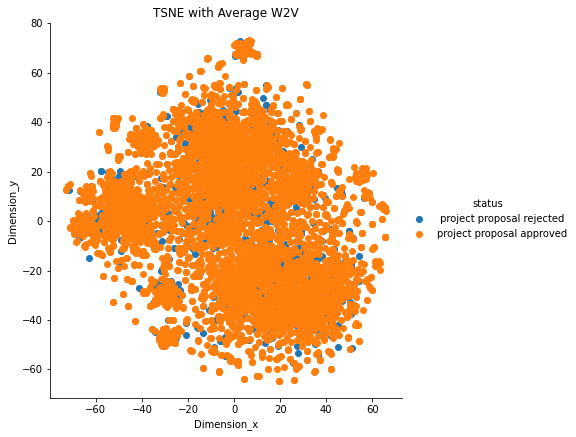

In [95]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.sparse import coo_matrix
x1= X_tfidf_w2v.tocsr()#https://stackoverflow.com/questions/30163830/accessing-elements-in-coo-matrix
x = x1[:5000]#taking first 5000 rows
y = project_data.project_is_approved
z= y.values.reshape(-1,1) #coverting it into a 1-d matrix
z1= z[:5000]
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())#converting sparse to dense matrix
for_tsne = np.hstack((X_embedding, z1))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','status'])
print(for_tsne_df.head(5))
for_tsne_df.status = for_tsne_df.status.map({0.0:" project proposal rejected", 1.0: "project proposal approved"})
plt.show()    
sns.FacetGrid(for_tsne_df, hue="status", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title('TSNE with Average W2V')
plt.show()     
        

### Observations
    1. Most of the points are overlapping with each other.

## Final Tsne plot

final matrix shape=  (109248, 13562)
   Dimension_x  Dimension_y  status
0   -37.496120    -0.475295     0.0
1    49.124222     9.938066     1.0
2    22.882620    47.543751     0.0
3   -55.930622   -23.448339     1.0
4   -13.447062   -47.343628     1.0


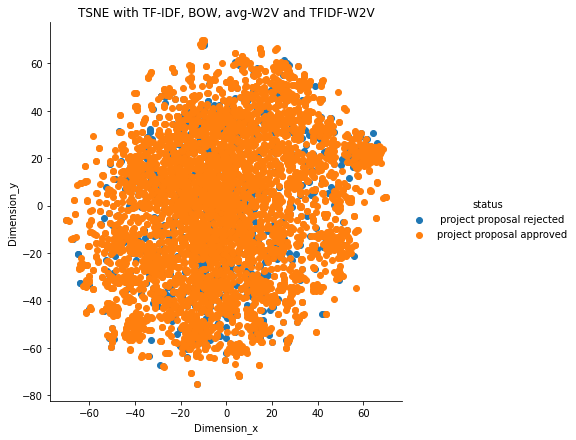

In [96]:
X_final= hstack((categories_one_hot, sub_categories_one_hot, text_tfidft,text_bowt,avg_w2vt_array,tfidf_w2vt_array, price_standardized, categories_state, categories_grade, categories_prefix))
print("final matrix shape= ",X_final.shape)

from sklearn.manifold import TSNE
import seaborn as sns
from scipy.sparse import coo_matrix
x1= X_final.tocsr()#https://stackoverflow.com/questions/30163830/accessing-elements-in-coo-matrix
x = x1[:5000]#taking first 5000 rows
y = project_data.project_is_approved
z= y.values.reshape(-1,1) #coverting it into a 1-d matrix
z1= z[:5000]
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())#converting sparse to dense matrix
for_tsne = np.hstack((X_embedding, z1))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','status'])
print(for_tsne_df.head(5))
for_tsne_df.status = for_tsne_df.status.map({0.0:" project proposal rejected", 1.0: "project proposal approved"})
plt.show()    
sns.FacetGrid(for_tsne_df, hue="status", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title('TSNE with TF-IDF, BOW, avg-W2V and TFIDF-W2V')
plt.show()

### Observation
    1. No significant observation can be made. Most of the points are overlapping in the final TSNE plot.
    2. We have concatenated all the features and Vectorized text data to form the final TSNE plot. 

<h2> 2.5 Summary </h2>

    1. We've visualised the data using exploratory data and tried to find patterns using T-Sne.
    2. We find small clusters in Tsne plots.
    3. There were significant observations made while performing Exploratory data analysis.
